In [1]:
from torchvision import datasets

# Initializing FashionMNIST
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True)

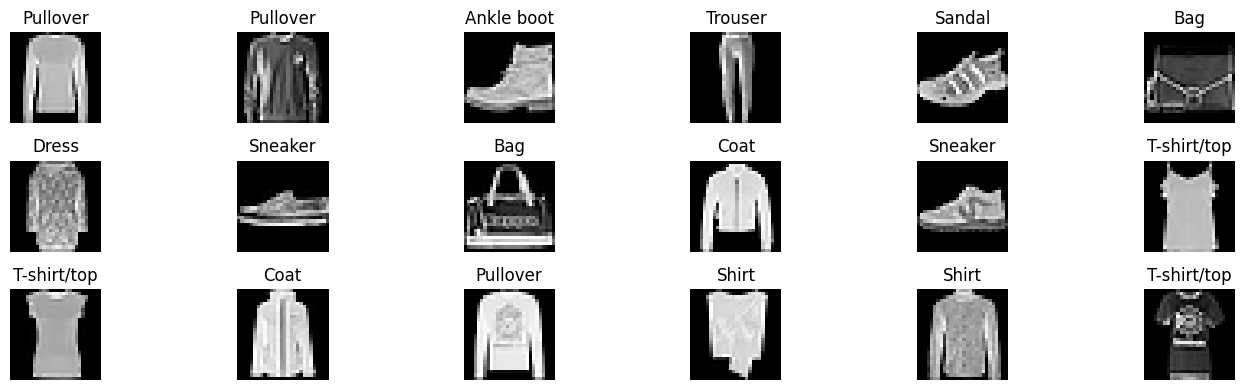

In [2]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(1)

fig = plt.figure(figsize=(16, 4))
rows, cols = 3, 6
class_names = train_val_dataset.classes

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()
    img, label = train_val_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [3]:
from torchvision import transforms

# FashionMNIST with no normalization
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())

In [4]:
# Calculating mean and std
imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)
mean = imgs.view(1, -1).mean(dim=1)
std = imgs.view(1, -1).std(dim=1)
mean, std

# Normalizing
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

# FashionMNIST with normalization
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_val_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.2860]), std=tensor([0.3530]))
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.2860]), std=tensor([0.3530]))
            ))

In [5]:
# 90% train, 10% validation
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Visualizing number of batches with the current batch size
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(1688, 188, 313)

In [7]:
from torch import nn

# Defining our LeNet5 model
class LeNet5V1(nn.Module):
    def __init__(self, use_dropout=False, use_batch_norm=False):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2))  # 28x28 -> 28x28
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(6))
        layers.append(nn.Tanh())
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))  # 14x14
        layers.append(nn.Conv2d(6, 16, kernel_size=5, stride=1))  # 10x10
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(16))
        layers.append(nn.Tanh())
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))  # 5x5
        
        self.feature = nn.Sequential(*layers)
        
        layers = []
        layers.append(nn.Flatten())
        layers.append(nn.Linear(16 * 5 * 5, 120))
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(120, 84))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(84, 10))
        
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

In [8]:
# Instantiating our models
model_baseline = LeNet5V1()
model_dropout = LeNet5V1(use_dropout=True)
model_l2 = LeNet5V1()
model_batch_norm = LeNet5V1(use_batch_norm=True)

In [9]:
from torch.optim import Adam
from torchmetrics import Accuracy

# Our training function
def train_model(model, train_loader, val_loader, epochs, optimizer, accuracy, weight_decay=0.0):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    accuracy = accuracy.to(device)
    
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(y_pred, y).item()
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                val_acc += accuracy(y_pred, y).item()
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch + 1}/{epochs} - Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")
    
    return train_accs, val_accs

In [10]:
# Train the Baseline model
train_acc_baseline, val_acc_baseline = train_model(
    model=model_baseline, 
    train_loader=train_dataloader, 
    val_loader=val_dataloader, 
    epochs=12, 
    optimizer=Adam, 
    accuracy=Accuracy(task='multiclass', num_classes=10)
)

# Train the Dropout model
train_acc_dropout, val_acc_dropout = train_model(
    model=model_dropout, 
    train_loader=train_dataloader, 
    val_loader=val_dataloader, 
    epochs=12, 
    optimizer=Adam, 
    accuracy=Accuracy(task='multiclass', num_classes=10)
)

# Train the L2 Regularization model
train_acc_l2, val_acc_l2 = train_model(
    model=model_l2, 
    train_loader=train_dataloader, 
    val_loader=val_dataloader, 
    epochs=12, 
    optimizer=Adam, 
    accuracy=Accuracy(task='multiclass', num_classes=10),
    weight_decay=0.01 # L2 regularization
)

# Train the Batch Normalization model
train_acc_batch_norm, val_acc_batch_norm = train_model(
    model=model_batch_norm, 
    train_loader=train_dataloader, 
    val_loader=val_dataloader, 
    epochs=12, 
    optimizer=Adam, 
    accuracy=Accuracy(task='multiclass', num_classes=10)
)


Epoch 1/12 - Train Accuracy: 0.8068, Val Accuracy: 0.8554
Epoch 2/12 - Train Accuracy: 0.8661, Val Accuracy: 0.8752
Epoch 3/12 - Train Accuracy: 0.8800, Val Accuracy: 0.8828
Epoch 4/12 - Train Accuracy: 0.8902, Val Accuracy: 0.8915
Epoch 5/12 - Train Accuracy: 0.8965, Val Accuracy: 0.8901
Epoch 6/12 - Train Accuracy: 0.9045, Val Accuracy: 0.8870
Epoch 7/12 - Train Accuracy: 0.9092, Val Accuracy: 0.8959
Epoch 8/12 - Train Accuracy: 0.9152, Val Accuracy: 0.9013
Epoch 9/12 - Train Accuracy: 0.9195, Val Accuracy: 0.9011
Epoch 10/12 - Train Accuracy: 0.9227, Val Accuracy: 0.8984
Epoch 11/12 - Train Accuracy: 0.9268, Val Accuracy: 0.8988
Epoch 12/12 - Train Accuracy: 0.9308, Val Accuracy: 0.9038
Epoch 1/12 - Train Accuracy: 0.7847, Val Accuracy: 0.8414
Epoch 2/12 - Train Accuracy: 0.8374, Val Accuracy: 0.8570
Epoch 3/12 - Train Accuracy: 0.8485, Val Accuracy: 0.8682
Epoch 4/12 - Train Accuracy: 0.8578, Val Accuracy: 0.8762
Epoch 5/12 - Train Accuracy: 0.8669, Val Accuracy: 0.8826
Epoch 6/12 

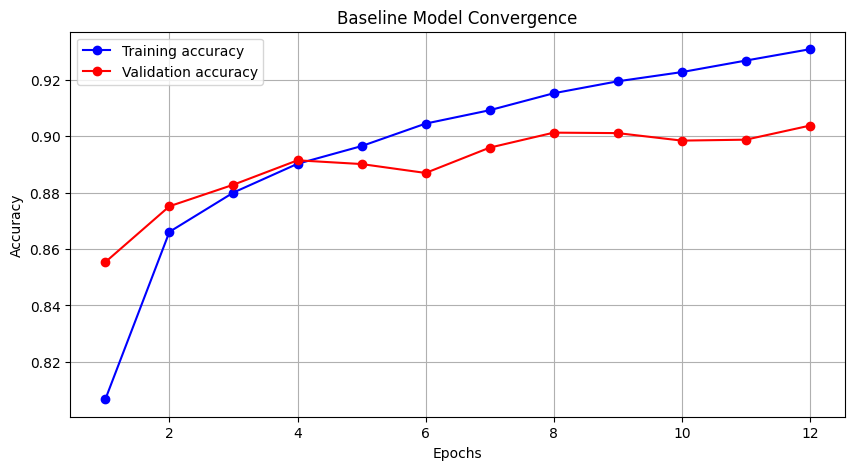

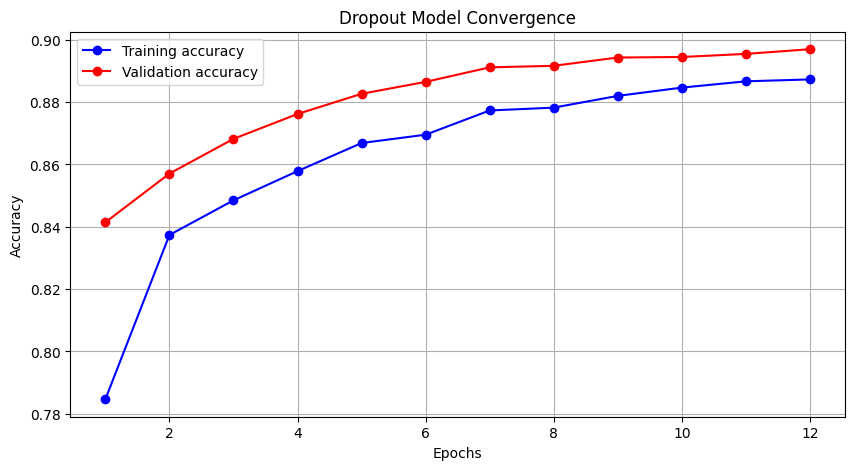

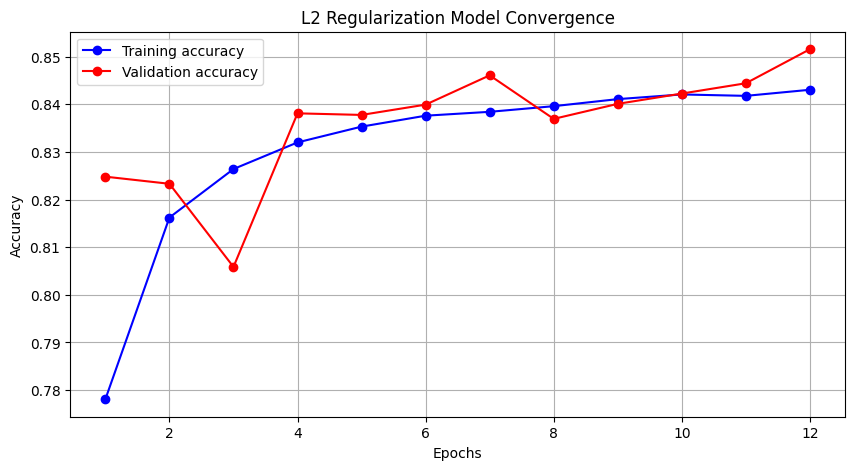

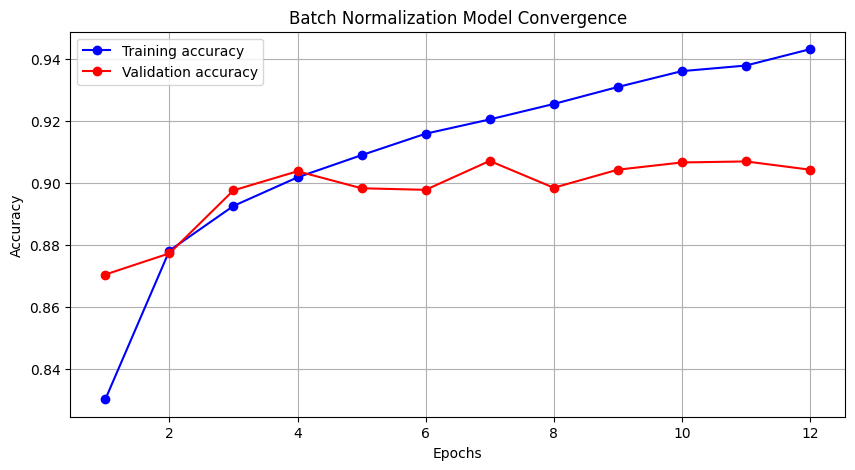

In [11]:
import matplotlib.pyplot as plt

# Plotting our convergence graphs
def plot_convergence(train_accs, val_accs, title):
    epochs = range(1, len(train_accs) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accs, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Baseline Model
plot_convergence(train_acc_baseline, val_acc_baseline, "Baseline Model Convergence")

# Plot for Dropout Model
plot_convergence(train_acc_dropout, val_acc_dropout, "Dropout Model Convergence")

# Plot for L2 Regularization Model
plot_convergence(train_acc_l2, val_acc_l2, "L2 Regularization Model Convergence")

# Plot for Batch Normalization Model
plot_convergence(train_acc_batch_norm, val_acc_batch_norm, "Batch Normalization Model Convergence")

In [12]:
import pandas as pd

# Compiling our final accuracies
final_accs = {
    'Model': [
        'Baseline Train', 'Baseline Validation', 
        'Dropout Train', 'Dropout Validation', 
        'L2 Regularization Train', 'L2 Regularization Validation', 
        'Batch Normalization Train', 'Batch Normalization Validation'
    ],
    'Accuracy': [
        train_acc_baseline[-1], val_acc_baseline[-1], 
        train_acc_dropout[-1], val_acc_dropout[-1], 
        train_acc_l2[-1], val_acc_l2[-1], 
        train_acc_batch_norm[-1], val_acc_batch_norm[-1]
    ]
}

# Displaying the df with accs
df_accs = pd.DataFrame(final_accs)
print(df_accs)

                            Model  Accuracy
0                  Baseline Train  0.930835
1             Baseline Validation  0.903757
2                   Dropout Train  0.887256
3              Dropout Validation  0.896941
4         L2 Regularization Train  0.843047
5    L2 Regularization Validation  0.851562
6       Batch Normalization Train  0.943035
7  Batch Normalization Validation  0.904255


In [ ]:
# Optional
# In my above code, it can be seen that our L2 Regularization model has the best validation accuracy below our threshold of 88%.
# So, I address that by tuning the hyperparameters and introducing an "optimized" L2 Regularization model below.
# Fixing L2 Regularization model (Since it is below 88%)
train_acc_l2_optimized, val_acc_l2_optimized = train_model(
    model=model_l2, 
    train_loader=train_dataloader, 
    val_loader=val_dataloader, 
    epochs=20,  # Increased epochs for better convergence
    optimizer=Adam,
    accuracy=Accuracy(task='multiclass', num_classes=10),
    weight_decay=0.001,  # Reduced weight decay for better generalization
)

In [ ]:
# Optional
# Plot for Optimized L2 Regularization Model
plot_convergence(train_acc_l2_optimized, val_acc_l2_optimized, "Optimized L2 Regularization Model Convergence")

In [ ]:
# Optional
# Compiling our final accuracy of our Optimized L2 Regularization Model
final_accs_optimized = {
    'Model': [
        'L2 Regularization Train', 'L2 Regularization Validation'
    ],
    'Accuracy': [
        train_acc_l2_optimized[-1], val_acc_l2_optimized[-1]
    ]
}

# Displaying the df with accs
l2_optimized_df_accs = pd.DataFrame(final_accs_optimized)
print(l2_optimized_df_accs)

In [ ]:
# Optional
# Saving our Optimized L2 Regularization Model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

print(f"Saving L2 Optimized model to {MODEL_PATH}")
torch.save(model_l2.state_dict(), MODEL_PATH / "lenet5v1_l2_optimized.pth")

In [ ]:
# Optional
# Loading the Optimized L2 Regularization model for further usage (if needed)
model_l2_optimized_loaded = LeNet5V1()
model_l2_optimized_loaded.load_state_dict(torch.load(MODEL_PATH / "lenet5v1_l2_optimized.pth"))

print("L2 Optimized model loaded successfully.")

In [ ]:
# Optional
# Saving our Baseline, Dropout, L2 Regularization, BN models
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Introducing a cleaner saving convention since we have multiple models
MODEL_NAMES = {
    "baseline": "lenet5_baseline_fashionmnist.pth",
    "dropout": "lenet5_dropout_fashionmnist.pth",
    "l2_regularization": "lenet5_l2_fashionmnist.pth",
    "batch_norm": "lenet5_batchnorm_fashionmnist.pth"
}
MODEL_SAVE_PATHS = {key: MODEL_PATH / name for key, name in MODEL_NAMES.items()}

print(f"Saving Baseline Model: {MODEL_SAVE_PATHS['baseline']}")
torch.save(model_baseline.state_dict(), MODEL_SAVE_PATHS['baseline'])

print(f"Saving Dropout Model: {MODEL_SAVE_PATHS['dropout']}")
torch.save(model_dropout.state_dict(), MODEL_SAVE_PATHS['dropout'])

print(f"Saving L2 Regularization Model: {MODEL_SAVE_PATHS['l2_regularization']}")
torch.save(model_l2.state_dict(), MODEL_SAVE_PATHS['l2_regularization'])

print(f"Saving Batch Normalization Model: {MODEL_SAVE_PATHS['batch_norm']}")
torch.save(model_batch_norm.state_dict(), MODEL_SAVE_PATHS['batch_norm'])


In [ ]:
# Optional
# Loading the Baseline, Dropout, L2 Regularization, BN models for further usage (if needed)
model_baseline_loaded = LeNet5V1()
model_baseline_loaded.load_state_dict(torch.load(MODEL_SAVE_PATHS['baseline']))

model_dropout_loaded = LeNet5V1(use_dropout=True)
model_dropout_loaded.load_state_dict(torch.load(MODEL_SAVE_PATHS['dropout']))

model_l2_loaded = LeNet5V1()
model_l2_loaded.load_state_dict(torch.load(MODEL_SAVE_PATHS['l2_regularization']))

model_batch_norm_loaded = LeNet5V1(use_batch_norm=True)
model_batch_norm_loaded.load_state_dict(torch.load(MODEL_SAVE_PATHS['batch_norm']))

print("All models loaded successfully.")